In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Reading and preprocessing images

According to the data information, we have 7,593 COVID-19 images and 6,893 normal(non covid) images. First we are going to choose 5000 images from these two groups. random_sample function used for random sampling without replacement.

In [2]:
import random

normal_img_path = '../input/large-covid19-ct-slice-dataset/curated_data/curated_data/1NonCOVID'
covid_img_path = '../input/large-covid19-ct-slice-dataset/curated_data/curated_data/2COVID'

normal_img_files = os.listdir(normal_img_path)
covid_img_files = os.listdir(covid_img_path)

normal_img_smpls_train = random.sample(normal_img_files, 5000)
covid_img_smpls_train = random.sample(covid_img_files, 5000)

Now we're going to read the imaging we have chosen using CV2. The shape of original images is 512  *  512  *  3 and reading them in original shape, take a lot of RAM capacity; So, we can resize them first and append them to arrays later. Then, we create an array for labeling the images.

In [3]:
import cv2

normal_img_train = []
for img_name in normal_img_smpls_train:
    image = cv2.imread(normal_img_path + '/' + img_name, 1)
    image = cv2.resize(image, dsize=(256,256), interpolation=cv2.INTER_CUBIC)
    normal_img_train.append(np.array(image))
        
covid_img_train = []
for img_name in covid_img_smpls_train:
    image = cv2.imread(covid_img_path + '/' + img_name, 1)
    image = cv2.resize(image, dsize=(256,256), interpolation=cv2.INTER_CUBIC)
    covid_img_train.append(np.array(image))

Let's see some random images of normal and covid CTs:

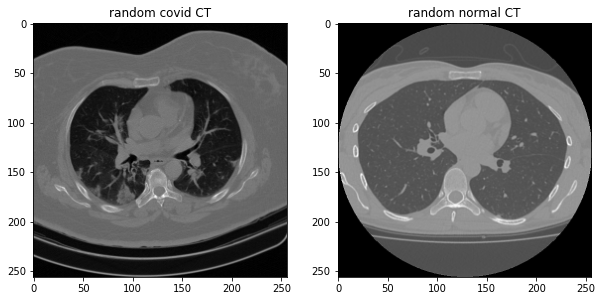

In [4]:
from matplotlib import pyplot as plt

covid_rndm = np.random.randint(0, len(covid_img_train))
rndm_covid_img = covid_img_train[covid_rndm]

normal_rndm = np.random.randint(0, len(normal_img_train))
rndm_normal_img = normal_img_train[normal_rndm]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
ax[0].imshow(np.uint8(rndm_covid_img))
ax[0].set_title('random covid CT')
ax[1].imshow(np.uint8(rndm_normal_img))
ax[1].set_title('random normal CT')
fig.show()

In [5]:
#concatenate lists of normal and covid images
train_images = normal_img_train + covid_img_train

# 0: normal(non covid)  
# 1: covid
train_images_labels = np.concatenate((np.zeros(len(normal_img_train)), np.ones(len(covid_img_train))), axis=None, dtype=np.float32)

# free useless memory
normal_img_train = []
covid_img_train = []

# Training custom vgg16 model

First we split the whole training images to train and validation sets

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(np.array(train_images), np.array(train_images_labels), test_size=0.2, random_state=42)

Here, we build a custom vgg16 model; custom because of 'kernel_initializer', 'activation' functions and amount of neurons 'dropout' we used! Actually, maybe vgg16 exactly use these setting too, I don't know :)))

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer, Lambda, Conv2D, Dropout, MaxPooling2D, Flatten, Dense

cnn_model = Sequential()
cnn_model.add(InputLayer(input_shape=(256,256,3)))
cnn_model.add(Lambda(lambda x: x/255.))   #Normalization

cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(Dropout(0.1))
cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(Dropout(0.1))
cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(4096, activation="relu"))
cnn_model.add(Dense(4096, activation="relu"))
cnn_model.add(Dense(1, activation="sigmoid"))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

2022-08-26 09:43:19.188999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 09:43:19.306770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 09:43:19.307551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 09:43:19.309094: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 128)     0

Now, we can fit our model. Here, we use two callbacks;
1. Early Stopping: use validation loss to monitoring the train process for prevent overfitting
2. Model Checkpoint: to save the model when minimum validation loss occurs at the given path

In [8]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/result', monitor='val_loss', mode='min')]

history = cnn_model.fit(x = np.asarray(X_train),
                        y = y_train,
                        batch_size = 20,
                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                        validation_data = (np.asarray(X_val), y_val),
                        verbose = 1,
                        epochs = 50)

2022-08-26 09:43:21.974845: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1572864000 exceeds 10% of free system memory.
2022-08-26 09:43:23.720574: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1572864000 exceeds 10% of free system memory.
2022-08-26 09:43:25.004576: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-08-26 09:43:27.292129: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


400/400 [==============================] - ETA: 0s - loss: 47.8001 - accuracy: 0.6683

2022-08-26 09:45:05.892141: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 393216000 exceeds 10% of free system memory.
2022-08-26 09:45:06.361456: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 393216000 exceeds 10% of free system memory.


400/400 [==============================] - 112s 252ms/step - loss: 47.8001 - accuracy: 0.6683 - val_loss: 0.4857 - val_accuracy: 0.8105
Epoch 2/50
400/400 [==============================] - 100s 250ms/step - loss: 0.4994 - accuracy: 0.7925 - val_loss: 0.4569 - val_accuracy: 0.8210
Epoch 3/50
400/400 [==============================] - 100s 250ms/step - loss: 0.4145 - accuracy: 0.8215 - val_loss: 0.3735 - val_accuracy: 0.8530
Epoch 4/50
400/400 [==============================] - 95s 238ms/step - loss: 0.3924 - accuracy: 0.8349 - val_loss: 0.3749 - val_accuracy: 0.8370
Epoch 5/50
400/400 [==============================] - 100s 250ms/step - loss: 0.3383 - accuracy: 0.8646 - val_loss: 0.3129 - val_accuracy: 0.8790
Epoch 6/50
400/400 [==============================] - 100s 250ms/step - loss: 0.3327 - accuracy: 0.8691 - val_loss: 0.3162 - val_accuracy: 0.8840
Epoch 7/50
400/400 [==============================] - 95s 238ms/step - loss: 0.2912 - accuracy: 0.8823 - val_loss: 0.2897 - val_accurac

To find best number of epochs for training:

In [18]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch = ', best_epoch)

Best epoch =  22


Plotting results of model fitting involvs accuracy, validation accuracy, loss and validation loss

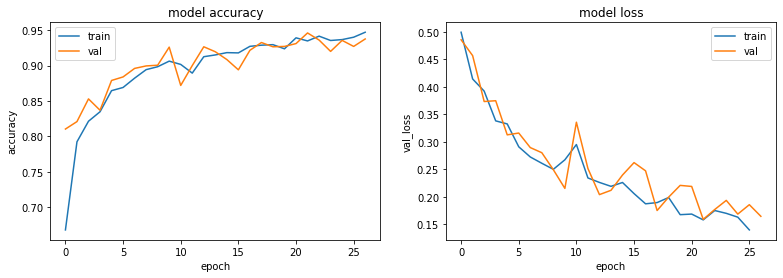

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'][1:])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper right')

fig.show()

# Test the model

We have chosen 5000 images from two classes for training; now, first we get the images that we did not use them before and select 1500 images from each class for test the model.

In [10]:
rest_of_normal_img_files = set(normal_img_files) - set(normal_img_smpls_train)
rest_of_covid_img_files = set(covid_img_files) - set(covid_img_smpls_train)

normal_img_smpls_test = random.sample(rest_of_normal_img_files, 1500)
covid_img_smpls_test = random.sample(rest_of_covid_img_files, 1500)

Like training phase, we read the images and resize them

In [11]:
normal_img_test = []
for img_name in normal_img_smpls_test:
    image = cv2.imread(normal_img_path + '/' + img_name, 1)
    image = cv2.resize(image, dsize=(256,256), interpolation=cv2.INTER_CUBIC)
    normal_img_test.append(np.array(image))
        
covid_img_test = []
for img_name in covid_img_smpls_test:
    image = cv2.imread(covid_img_path + '/' + img_name, 1)
    image = cv2.resize(image, dsize=(256,256), interpolation=cv2.INTER_CUBIC)
    covid_img_test.append(np.array(image))

In [12]:
test_images = normal_img_test + covid_img_test
test_images_labels = np.concatenate((np.zeros(len(normal_img_test)), np.ones(len(normal_img_test))), axis=None, dtype=np.float32)

normal_img_test = []
covid_img_test = []

'evaluate' method returns the loss value & metrics values (accuracy in this project) for the model.

In [13]:
cnn_model.evaluate(x = np.asarray(test_images),
                   y = test_images_labels,
                   verbose=1)

2022-08-26 10:28:25.192678: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 589824000 exceeds 10% of free system memory.


94/94 [==============================] - 13s 105ms/step - loss: 0.1560 - accuracy: 0.9447


[0.15603162348270416, 0.9446666836738586]

In fact, loss and accuracy values alone can not describe our model! So we use 'classification_report' function from sklearn to get Precision, Recall & F1 Scores which express the model better.

![](https://www.researchgate.net/profile/Nittaya-Kerdprasop/publication/329526806/figure/fig1/AS:745215891623936@1554684722023/Example-of-confusion-matrix-True-Positive-TP-The-number-of-instances-that-a-model.ppm)

* **Precision:**

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question 'precision' answers is: Of all patients that labeled as covid, how many actually covid patient?

Precision = TP / TP+FP

* **Recall:**

Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question 'recall' answers is: Of all the patients that truly have covid, how many did we label?

Recall = TP / TP+FN

* **F1 score:**

F1 Score is the weighted average of 'precision' and 'recall'. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [14]:
from sklearn.metrics import classification_report

model_prd = cnn_model.predict(x = np.asarray(test_images))
for i in range(len(model_prd)):
    if model_prd[i] >= 0.5:
        model_prd[i] = 1
    elif model_prd[i] < 0.5:
        model_prd[i] = 0

classes = ['Class Normal', 'Class Covid']
print(classification_report(y_true = test_images_labels,
                      y_pred = model_prd,
                      target_names = classes))

              precision    recall  f1-score   support

Class Normal       0.92      0.98      0.95      1500
 Class Covid       0.98      0.91      0.94      1500

    accuracy                           0.94      3000
   macro avg       0.95      0.94      0.94      3000
weighted avg       0.95      0.94      0.94      3000

